<font color="#242343"> **Don’t Get Lost in the Random Forests: A Beginner’s Guide - Tutorial**
---
<font color="#00d3ef"> Moses Bomera, Data Scientist - [Emata Uganda](https://www.emata.ug/) </font>

In [1]:
# @title [IMPORTANT] CLICK PLAY ICON TO CONFIGURE NOTEBOOK. {display-mode: "form"}
%%capture
# Install these libraries
!pip install dython
!pip install category_encoders

# Download the dataset to use.
!wget  https://raw.githubusercontent.com/MosesBomera/DatafestKampala2021/main/weight_class_data.csv

# Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
import seaborn as sns
from scipy import stats

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_predict

from dython.nominal import associations, correlation_ratio
%matplotlib inline
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# Directory to save mpl plots.
ROOT_DIR = "."

# Utility functions
def feature_counts(feature, target):
    """
        Plots the count of a given value of a variable with regards to the target varaible.

        feature <str> the feature to analyze.
        target <str> the target variable.
    """
    fig, ax = plt.subplots(figsize=(15, 9))
    ax = sns.countplot(x=feature, hue=target, data=df)
    # for p in ax.patches:
    #     height = p.get_height()
    #     ax.text(p.get_x() + p.get_width()/2.0, 
    #             height + 3,
    #            '{:1.4f}'.format(height/df.shape[0]),
    #            ha='center')

def plot_scores(precision, recall, fscore):
    """
        Plots the three scores for each class.
    """
    width = 0.25
    
    x = np.arange(0,7)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax = plt.subplot(111)
    p = ax.bar(x - width, precision, width=0.2, color='b', align='center')
    r = ax.bar(x , recall, width=0.2, color='g', align='center')
    f = ax.bar(x + width, fscore, width=0.2, color='r', align='center')
    ax.legend( (p[0], r[0], f[0]), ('precision', 'recall', 'f1_score') )
    plt.show()

def scores(clf, y_true):
    """
        Return the precision_score, recall_score and f1_score for a given classifier.
    """
    y_pred = cross_val_predict(clf, X_train, y_train, cv=5)
    fscore = f1_score(y_true, y_pred, average=None)
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    print(f"precision: {precision}", f"recall: {recall}",f"f1_score: {fscore}", sep='\n')
    return fscore, precision, recall 

## <font color="#242343"> **Load the data**

The table below gives a description of the not so clear column names.


| Column | Definition |
| --- | --- |
| Gender | Gender of the research subject |
| Age | Age of the research subject|
| Height | Height of the research subject|
| Weight | Weight of the research subject |
| family_history_with_overweight | family history of obesity |
| FAVC | Do you eat high calorific food frequently? |
| FCVC | Do you usually eat vegetables in your meals? |
| NCP | How many meals do you have daily? |
| CAEC | Do you eat any food between meals? |
| SMOKE | Does the research subject smoke |
| CH2O | How much water do you drink daily |
| SCC | Do you monitor the calories you eat daily |
| FAF | How often do you exercise? |
| TUE | how much time do you use technological devices such as cell phone? |
| CALC | How often do you drink alcohol |
| MTRANS | Which transportation mode do you use most frequently? |
| Weight_classification | The weight classification given the features. |

In [3]:
df = pd.read_csv('weight_class_data.csv')
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Weight_classification
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


<font color="#0862f0"> **What kind of task can we come up with?**

## <font color="#242343"> **Exploratory Data Analysis (EDA)**

In [4]:
# general information about the dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

>- The dataset has 2111 instances.
- The dataset has 16 features, and 1 target variable.
- There aren't any null values.
-There are both categorical and numerical features, nine and eight respectively.

In [5]:
# Descriptive statistics for the dataset to ascertain the central tendency.
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


### <font color="#242343"> **Feature Types**
***
**Notes** <br>
**Categorical Type:**
- **Nominal** type has two or more categories that have no intrinsic order.
    > - `MTRANS`

- **Dichotomous** type, is a nominal variable with only two categories.
   > - `Gender`
   > - `family_history_with_overweight`
   > - `FAVC`
   > - `SMOKE`
   > - `SCC`
  
- **Ordinal** variables that have two or more categories just like nominal variables but can be ranked or ordered.
   > - `FCVC*`
   > - `NCP*`
   > - `CAEC`
   > - `CH2O*`
   > - `FAF*`
   > - `TUE*`
   > - `CALC`
***
**Numerical Type:**
- **Continuous**
   > - `Age`
   > - `Height`
   > - `Weight`
   
*Nominal values already encoded.

Relations between features and the target variable `Weight_classification`.

In [6]:
mask = df.dtypes == np.object
categorical_cols = df.columns[mask]
categorical_cols

Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS', 'Weight_classification'],
      dtype='object')

The section contains an analysis of correlations between the target variable using the measures below:
***
**Notes:**
- For the **categorical-to-categorical** cases, Cramer's V is used, it a measure of association between two categorical features, gives the association value in a range of [0,1], where 0 means no association and 1 is full association.
- For **categorical-to-continuous** cases, correlation ratio is used, it is defined as the weighted variance of the mean of each category divided by the variance of all samples, for two values, it gives an output between 0 and 1, the closer the value is to one, the stronger the relation.
- Finally, for **continuous-to-continuous** cases, the Pearson's R method is used. It gives a value between 1 and -1, where 1 is positive strong correlation while -1 is strong negative correlation.

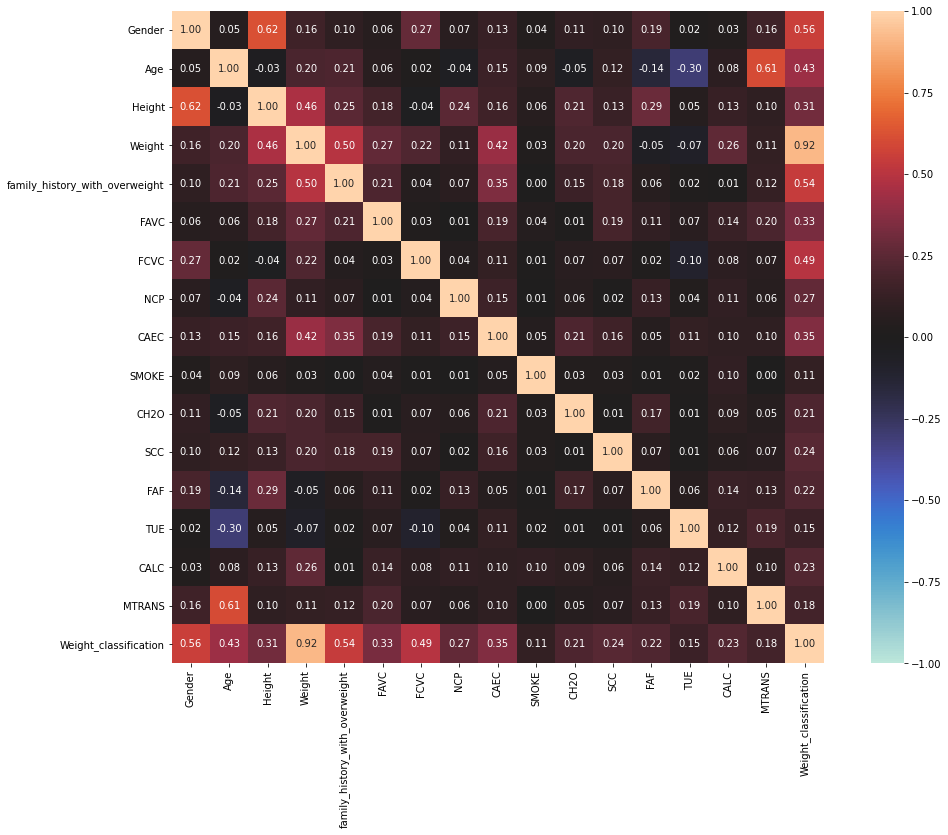

In [7]:
# The associations method from dython package is used, it neatly calculates the respective correlation given
# whether the case is categorical or continuous.
corr_matrix = associations(df, figsize=(17, 12));

<font color="#0862f0"> **Question: What information do we get from the correlation matrix about the features and the target?**

In [8]:
corr_matrix['corr']['Weight_classification'].sort_values(ascending=False)

Weight_classification             1.000000
Weight                            0.921231
Gender                            0.555773
family_history_with_overweight    0.540307
FCVC                              0.492536
Age                               0.426465
CAEC                              0.352314
FAVC                              0.328243
Height                            0.314281
NCP                               0.266511
SCC                               0.235500
CALC                              0.225146
FAF                               0.217926
CH2O                              0.209958
MTRANS                            0.178516
TUE                               0.148218
SMOKE                             0.111294
Name: Weight_classification, dtype: float64

Focus on the top two categorical features to understand, how each feature associates with a weight classification.

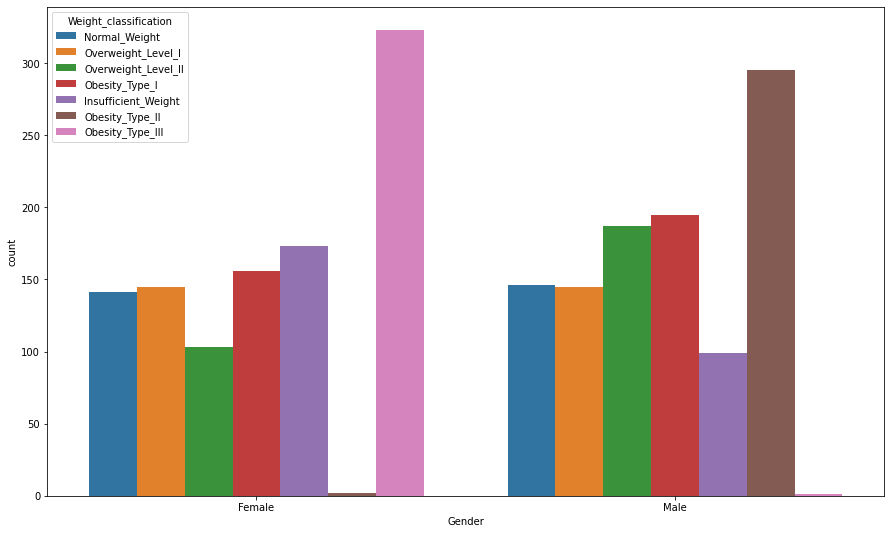

In [9]:
# Gender
feature_counts('Gender', 'Weight_classification')

- `Obesity_Type_III` is most prevalent in the sample.

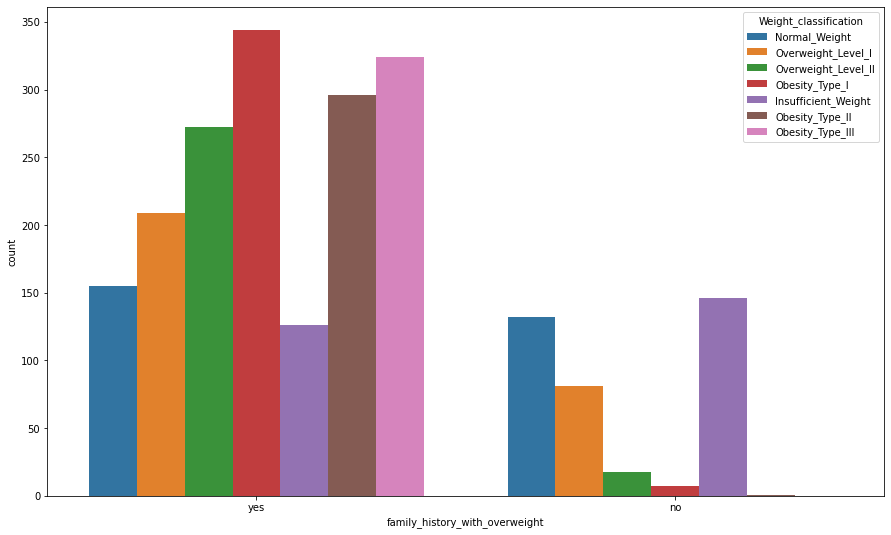

In [10]:
feature_counts('family_history_with_overweight', 'Weight_classification')

- Obesity is highly likely amongst people that have family history wth overweight.
- `Normal_weight` is within the same range among the two possibilities.

<font color="#0862f0"> **Question: Given the EDA, what features should be of interest to us?**

In [11]:
# Make a copy of the data.
df_copy = df.copy(deep=True)

In [12]:
# How well represented is each class?
df_copy['Weight_classification'].value_counts(normalize=True)

Obesity_Type_I         0.166272
Obesity_Type_III       0.153482
Obesity_Type_II        0.140692
Overweight_Level_I     0.137376
Overweight_Level_II    0.137376
Normal_Weight          0.135955
Insufficient_Weight    0.128849
Name: Weight_classification, dtype: float64

<font color="#0862f0"> **What could be the potential good features?**

## <font color="#242343"> **Modeling**

<font color="#242343"> **Train test split** <br>
---
**Notes:**
The data split should ensure that the different classifications are equally distributed between the train and test set.

<font color="#0862f0">**Why is this important?**

In [13]:
# Encode the target variable before splitting, to ensure uniform encoding strategy.
import category_encoders as ce
target_mapping = [{"col":'Weight_classification', 
                   "mapping": {'Insufficient_Weight':0, 
                               'Normal_Weight':1, 
                               'Overweight_Level_I': 2, 
                                'Overweight_Level_II': 3,
                                'Obesity_Type_I': 4,
                                'Obesity_Type_II': 5,
                                'Obesity_Type_III': 6}}]
target_encoder = ce.OrdinalEncoder(mapping = target_mapping, return_df = True)
# Assign to the same name.
df_copy = target_encoder.fit_transform(df_copy)

In [14]:
df_copy.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Weight_classification
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,1
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,1
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,1
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,2
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,3


In [15]:
# Train test split using the stratified approach.
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in split.split(df_copy, df_copy["Weight_classification"]):
    train = df_copy.loc[train_index]
    test = df_copy.loc[test_index]

In [16]:
# Train set distributions
train['Weight_classification'].value_counts() / len(train)

4    0.166403
6    0.153239
5    0.140600
3    0.137441
2    0.137441
1    0.135861
0    0.129015
Name: Weight_classification, dtype: float64

In [17]:
# Test set distributions
test['Weight_classification'].value_counts() / len(test)

4    0.165094
6    0.155660
5    0.141509
3    0.136792
2    0.136792
1    0.136792
0    0.127358
Name: Weight_classification, dtype: float64

In [18]:
# Number of instances.
train.shape, test.shape

((1899, 17), (212, 17))

## <font color="#242343"> **Split the features and the target**

In [19]:
# Drop the least five uncorrelated features, Weight_classification is not removed per se
# but rather seperated from the dataset as it is the target variable.
dropped = ['FAF', 'CH2O', 'MTRANS', 'TUE', 'SMOKE', 'Weight_classification']

In [20]:
# Create the features dataframe.
X_train_cat = train.drop(dropped, axis=1)
y_train = train['Weight_classification'].copy(deep=True)

X_test_cat = test.drop(dropped, axis=1)
y_test = test['Weight_classification'].copy(deep=True)

In [21]:
X_train_cat.shape, X_test_cat.shape

((1899, 11), (212, 11))

In [22]:
X_train_cat.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SCC,CALC
677,Female,19.665881,1.676346,49.105025,no,no,2.720701,3.000000,Sometimes,no,Sometimes
643,Male,19.962470,1.756338,54.982340,yes,yes,2.277436,3.502604,Sometimes,no,no
908,Male,23.562135,1.717432,75.371244,yes,yes,2.000000,3.000000,Sometimes,no,Sometimes
1060,Female,34.281681,1.673333,77.205685,yes,yes,2.689929,1.835543,Sometimes,no,no
1444,Female,23.652435,1.562724,80.535698,yes,yes,2.000000,1.000000,Sometimes,no,no


In [23]:
import category_encoders as ce
ordinal_cols_mapping = [{"col":'CAEC', "mapping": {'no':0, 'Sometimes':1, 'Frequently': 2, 'Always': 3}},
                        {"col":'CALC', "mapping": {'no':0, 'Sometimes':1, 'Frequently': 2, 'Always': 3}}]

In [24]:
ordinal_encoder = ce.OrdinalEncoder(mapping = ordinal_cols_mapping, return_df = True)  
ordinal_train_enc = ordinal_encoder.fit_transform(X_train_cat)

In [25]:
ordinal_train_enc.shape

(1899, 11)

In [26]:
# Onehot encode dichotomus columns.
one_hot = ce.OneHotEncoder()
one_hot_train = one_hot.fit_transform(ordinal_train_enc)

In [27]:
one_hot_train.shape

(1899, 15)

In [28]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scaled = ss.fit_transform(one_hot_train)

In [29]:
X_train = pd.DataFrame(scaled, columns=one_hot_train.columns)
X_train.head()

,Gender_1,Gender_2,Age,Height,Weight,family_history_with_overweight_1,family_history_with_overweight_2,FAVC_1,FAVC_2,FCVC,NCP,CAEC,SCC_1,SCC_2,CALC
0,1.006869,-1.006869,-0.733570,-0.256714,-1.429994,2.129893,-2.129893,2.713971,-2.713971,0.565333,0.410488,-0.30261,0.220436,-0.220436,0.517476
1,-0.993178,0.993178,-0.687024,0.602489,-1.204767,-0.469507,0.469507,-0.368464,0.368464,-0.265000,1.054484,-0.30261,0.220436,-0.220436,-1.405590
2,-0.993178,0.993178,-0.122103,0.184596,-0.423438,-0.469507,0.469507,-0.368464,0.368464,-0.784699,0.410488,-0.30261,0.220436,-0.220436,0.517476
3,1.006869,-1.006869,1.560193,-0.289077,-0.353139,-0.469507,0.469507,-0.368464,0.368464,0.507691,-1.081552,-0.30261,0.220436,-0.220436,-1.405590
4,1.006869,-1.006869,-0.107931,-1.477140,-0.225529,-0.469507,0.469507,-0.368464,0.368464,-0.784699,-2.152148,-0.30261,0.220436,-0.220436,-1.405590


## <font color="#242343"> **Using a Random Forest Model to predict weight classification.**

In [30]:
# DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

max_depth = range(1,30)
max_features = [21,22,23,24,25,26,28,29,30,'auto']
criterion=["entropy", "gini"]

param = {'max_depth':max_depth, 
         'max_features':max_features, 
         'criterion': criterion}
grid_dtc = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid = param,
    verbose=1,
    cv=StratifiedKFold(n_splits=20, random_state=15, shuffle=True),
    n_jobs = -1
  )
grid_dtc.fit(X_train, y_train)

Fitting 20 folds for each of 580 candidates, totalling 11600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 522 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 5322 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 11600 out of 11600 | elapsed:   35.5s finished


GridSearchCV(cv=StratifiedKFold(n_splits=20, random_state=15, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
         

In [31]:
print(grid_dtc.best_score_)
print(grid_dtc.best_params_)
print(grid_dtc.best_estimator_)

0.8688521836506158
{'criterion': 'entropy', 'max_depth': 16, 'max_features': 'auto'}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=16, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [32]:
feature_importances = pd.DataFrame(grid_dtc.best_estimator_.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False).head(5)

,importance
Weight,0.461107
Height,0.112578
Age,0.108434
family_history_with_overweight_2,0.079809
Gender_1,0.045127


In [33]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

n_estimators = [140,145,150,155,160];
max_depth = range(1,10);
criterions = ['gini', 'entropy'];
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)

parameters = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'criterion': criterions
              
        }
grid_rfc = GridSearchCV(
    estimator=RandomForestClassifier(max_features='auto'),
    param_grid=parameters,
    cv=cv,
    verbose=1,
    n_jobs=-1
  )
grid_rfc.fit(X_train,y_train) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  4.6min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=15, test_size=0.3,
            train_size=None),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
      

In [34]:
print(grid_rfc.best_score_)
print(grid_rfc.best_params_)
print(grid_rfc.best_estimator_)

0.926140350877193
{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 155}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=155,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [35]:
best_rfc = grid_rfc.best_estimator_
feature_importances = pd.DataFrame(best_rfc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False).head(5)

,importance
Weight,0.396969
FCVC,0.097079
Age,0.092765
Height,0.079504
Gender_1,0.057285


## <font color="#242343"> **Evaluation**
>- **Precision** measures how good the model is when the prediction is positive.
- **Recall** measures how good the model is at correctly predicting positive classes.
- **F1 score** is the weighted average of precision and recall. The closer the score is to one(1), the better the model.

In [36]:
fscore, precision, recall = scores(grid_dtc.best_estimator_, y_train);

precision: [0.89873418 0.69019608 0.7248062  0.73722628 0.865625   0.96212121
 0.99656357]
recall: [0.86938776 0.68217054 0.7164751  0.77394636 0.87658228 0.95131086
 0.99656357]
f1_score: [0.88381743 0.68615984 0.72061657 0.75514019 0.87106918 0.9566855
 0.99656357]


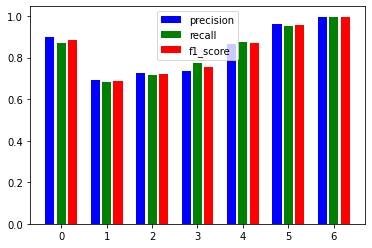

In [37]:
plot_scores(precision, recall, fscore)

In [38]:
fscore, precision, recall = scores(grid_rfc.best_estimator_, y_train)

precision: [0.9665272  0.80985915 0.9        0.86891386 0.95846645 0.99245283
 1.        ]
recall: [0.94285714 0.89147287 0.82758621 0.88888889 0.94936709 0.98501873
 1.        ]
f1_score: [0.95454545 0.84870849 0.86227545 0.87878788 0.95389507 0.9887218
 1.        ]


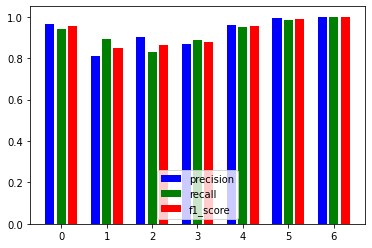

In [39]:
plot_scores(precision, recall, fscore)

## <font color="#242343"> **Evaluation on Test set**

In [40]:
# Prepare the test set                                
ordinal_encoder = ce.OrdinalEncoder(mapping=ordinal_cols_mapping, return_df=True)  
ordinal_test_enc = ordinal_encoder.fit_transform(X_test_cat)
one_hot = ce.OneHotEncoder()
one_hot_test = one_hot.fit_transform(ordinal_test_enc)
test_ss = StandardScaler()
test_scaled = test_ss.fit_transform(one_hot_test)
X_test = pd.DataFrame(test_scaled, columns=one_hot_test.columns)

In [41]:
# Final model, select the model that performed best on train set.
model = grid_rfc.best_estimator_
# Fit the model to the data.
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=155,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

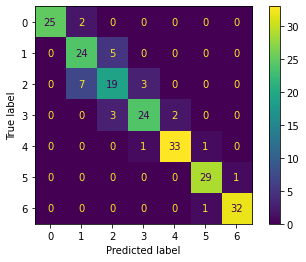

In [42]:
plot_confusion_matrix(model, X_test, y_test)
plt.show()

<font color="#0862f0">**EXERCISE:**<br>
**1. Calculate the recall, precision and f1_score.** <br>
**2. Plot your results.**

## <font color="#242343"> **Visualizing a Tree in the Random Forest**

In [65]:
# Get the class name mapping
x = target_encoder.mapping[0]['mapping']

# Swap keys and values
y = dict((v,k) for k,v in x.items())

# order the class names according to the mapping.
class_names = [y[idx] for idx in range(len(y))]
class_names

['Insufficient_Weight',
 'Normal_Weight',
 'Overweight_Level_I',
 'Overweight_Level_II',
 'Obesity_Type_I',
 'Obesity_Type_II',
 'Obesity_Type_III']

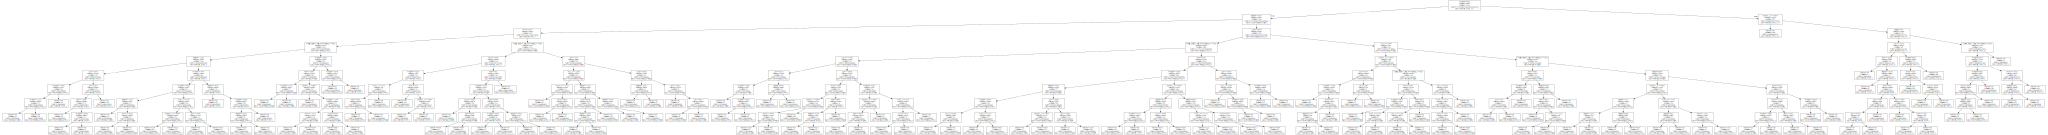

In [66]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
    model.estimators_[0],
    out_file = os.path.join(ROOT_DIR, "a_tree_in_the_forest.dot"),
    feature_names=X_train.columns,
    class_names=class_names
)

Source.from_file(os.path.join(ROOT_DIR, "a_tree_in_the_forest.dot"))

## <font color="#242343"> **Body Mass Index**

A regular measure, [Body Mass Index (BMI)](https://en.wikipedia.org/wiki/Body_mass_index), used to categorize a person as underweight, normal weight, overweight, or obese, it is calculated using `height` and `weight`, these are two features that exist in this dataset.

In [ ]:
# Body Mass Index
def bmi(weight, height):
    """
        Calculates the body mass index.
    """
    return weight / (height**2)

df_copy['bmi'] = bmi(df_copy['Weight'], df_copy['Height'])

In [ ]:
# Correlation of the new variable, using the correlation ratio (categorical-continuous case)
correlation_ratio(df_copy['Weight_classification'], df_copy['bmi'])

The Random Forest, with the training and modeling, estimates this function.